In [2]:
import os
import torch
import numpy as np
import cv2
from PIL import Image, ImageOps
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config

# Set the environment variable for Torch Hub
os.environ['TORCH_HOME'] = '.'

# Load the pre-trained ZoeD_N depth estimation model
model_zoe_n = torch.hub.load(repo_or_dir=".", model="ZoeD_N", source="local", pretrained=True)

# Load the custom YOLOv5 model
yolo = torch.hub.load(
    repo_or_dir='yolov5',
    model='custom',
    path='models/TC3-PPE_Detector_v3.pt',
    source='local'
)

# Check if GPU is available, otherwise use CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Move the models to the appropriate device
zoe = model_zoe_n.to(DEVICE)
yolo.to("cuda")

# Define gradient colors for depth visualization
red, green, yellow = (255, 0, 0), (0, 255, 0), (255, 255, 0)

# Define color map for different object classes
color_map = {
    'truck': (0, 0, 255),  # Red
    'safety': (0, 255, 0),  # Green
    'illegal': (255, 0, 0),  # Blue
    'cone': (255, 255, 0),  # Yellow
}


img_size [384, 512]
Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt


YOLOv5 🚀 2022-8-10 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)



Loaded successfully


Fusing layers... 
Model summary: 212 layers, 20873139 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [10]:
def predict_and_process(file, model_zoe_n, yolo):
    # Load the image and convert to RGB format
    img_pil = Image.open(file).convert("RGB")

    # Run object detection using YOLOv5
    outputs = yolo(img_pil).pandas().xyxy[0]
    outputs = outputs[outputs['confidence'] > 0.5]

    # Estimate depth using the depth estimation model
    depth_numpy = model_zoe_n.infer_pil(img_pil)

    # Normalize depth values between 0 and 255
    depth_int = (255 * (depth_numpy - depth_numpy.min()) / (depth_numpy.max() - depth_numpy.min())).astype(np.uint8)

    # Convert the depth array to a PIL image and colorize it
    depth_pil = Image.fromarray(depth_int)
    depth_col = ImageOps.colorize(depth_pil, red, green, yellow)

    # Blend the depth color image with the original image
    result_img = Image.blend(depth_col, img_pil, alpha=0.2)
    img_arr = np.array(result_img)

    # Process the object detection results and depth information
    results = process_predictions(outputs, depth_int)

    # Draw rectangles around detected objects
    draw_rectangles(img_arr, results)

    # Return the processed image
    return results,Image.fromarray(img_arr)

def process_predictions(outputs, depth_int):
    results = {}
    # Loop through the detected objects and compute depth and area
    for i, co in outputs.iterrows():
        y1, y2 = int(co['ymin']), int(co['ymax'])
        x1, x2 = int(co['xmin']), int(co['xmax'])
        deep = int(np.median(depth_int[y1:y2, x1:x2]))

        # Store object attributes in a dictionary
        results[str(i)] = {c: str(co[c]) for c in co.index}
        results[str(i)]['deep'] = str(deep)
        results[str(i)]['area'] = (x2 - x1) * (y2 - y1)

    return results

def draw_rectangles(img_arr, results):
    # Loop through the detected objects and draw rectangles around them
    for key in results:
        x1, y1 = int(float(results[key]['xmin'])), int(float(results[key]['ymin']))
        x2, y2 = int(float(results[key]['xmax'])), int(float(results[key]['ymax']))
        area = results[key]['area']

        # Draw rectangles for objects with area larger than 1200
        if area > 1200:
            deep = int(results[key]['deep'])
            name = results[key]['name']
            color = color_map.get(name, (255, 255, 255))
            thickness = 2
            cv2.rectangle(img_arr, (x1, y1), (x2, y2), color, thickness)

            # Add object class name and depth value as text
            font = cv2.FONT_HERSHEY_SIMPLEX
            (text_width, text_height), _ = cv2.getTextSize(name, font, 1, 2)
            text_x, text_y = x1, y1 - text_height
            cv2.putText(img_arr, f'{name} DS:{deep}', (text_x, text_y), font, 0.5, color, 2)


{'0': {'xmin': '828.0166625976562', 'ymin': '122.06385040283203', 'xmax': '1657.7633056640625', 'ymax': '870.5299072265625', 'confidence': '0.9901986718177795', 'class': '3', 'name': 'truck', 'deep': '76', 'area': 620092}, '1': {'xmin': '1596.15087890625', 'ymin': '919.9769287109375', 'xmax': '1685.2203369140625', 'ymax': '992.0206298828125', 'confidence': '0.9681035876274109', 'class': '4', 'name': 'filling', 'deep': '47', 'area': 6497}, '2': {'xmin': '837.5407104492188', 'ymin': '807.1380615234375', 'xmax': '952.5177612304688', 'ymax': '1076.2327880859375', 'confidence': '0.9570273756980896', 'class': '1', 'name': 'illegal', 'deep': '36', 'area': 30935}, '3': {'xmin': '848.041748046875', 'ymin': '383.7715759277344', 'xmax': '881.9803466796875', 'ymax': '439.5290222167969', 'confidence': '0.9550986289978027', 'class': '2', 'name': 'cone', 'deep': '145', 'area': 1848}, '4': {'xmin': '506.871826171875', 'ymin': '789.8355712890625', 'xmax': '632.4610595703125', 'ymax': '1061.030395507812

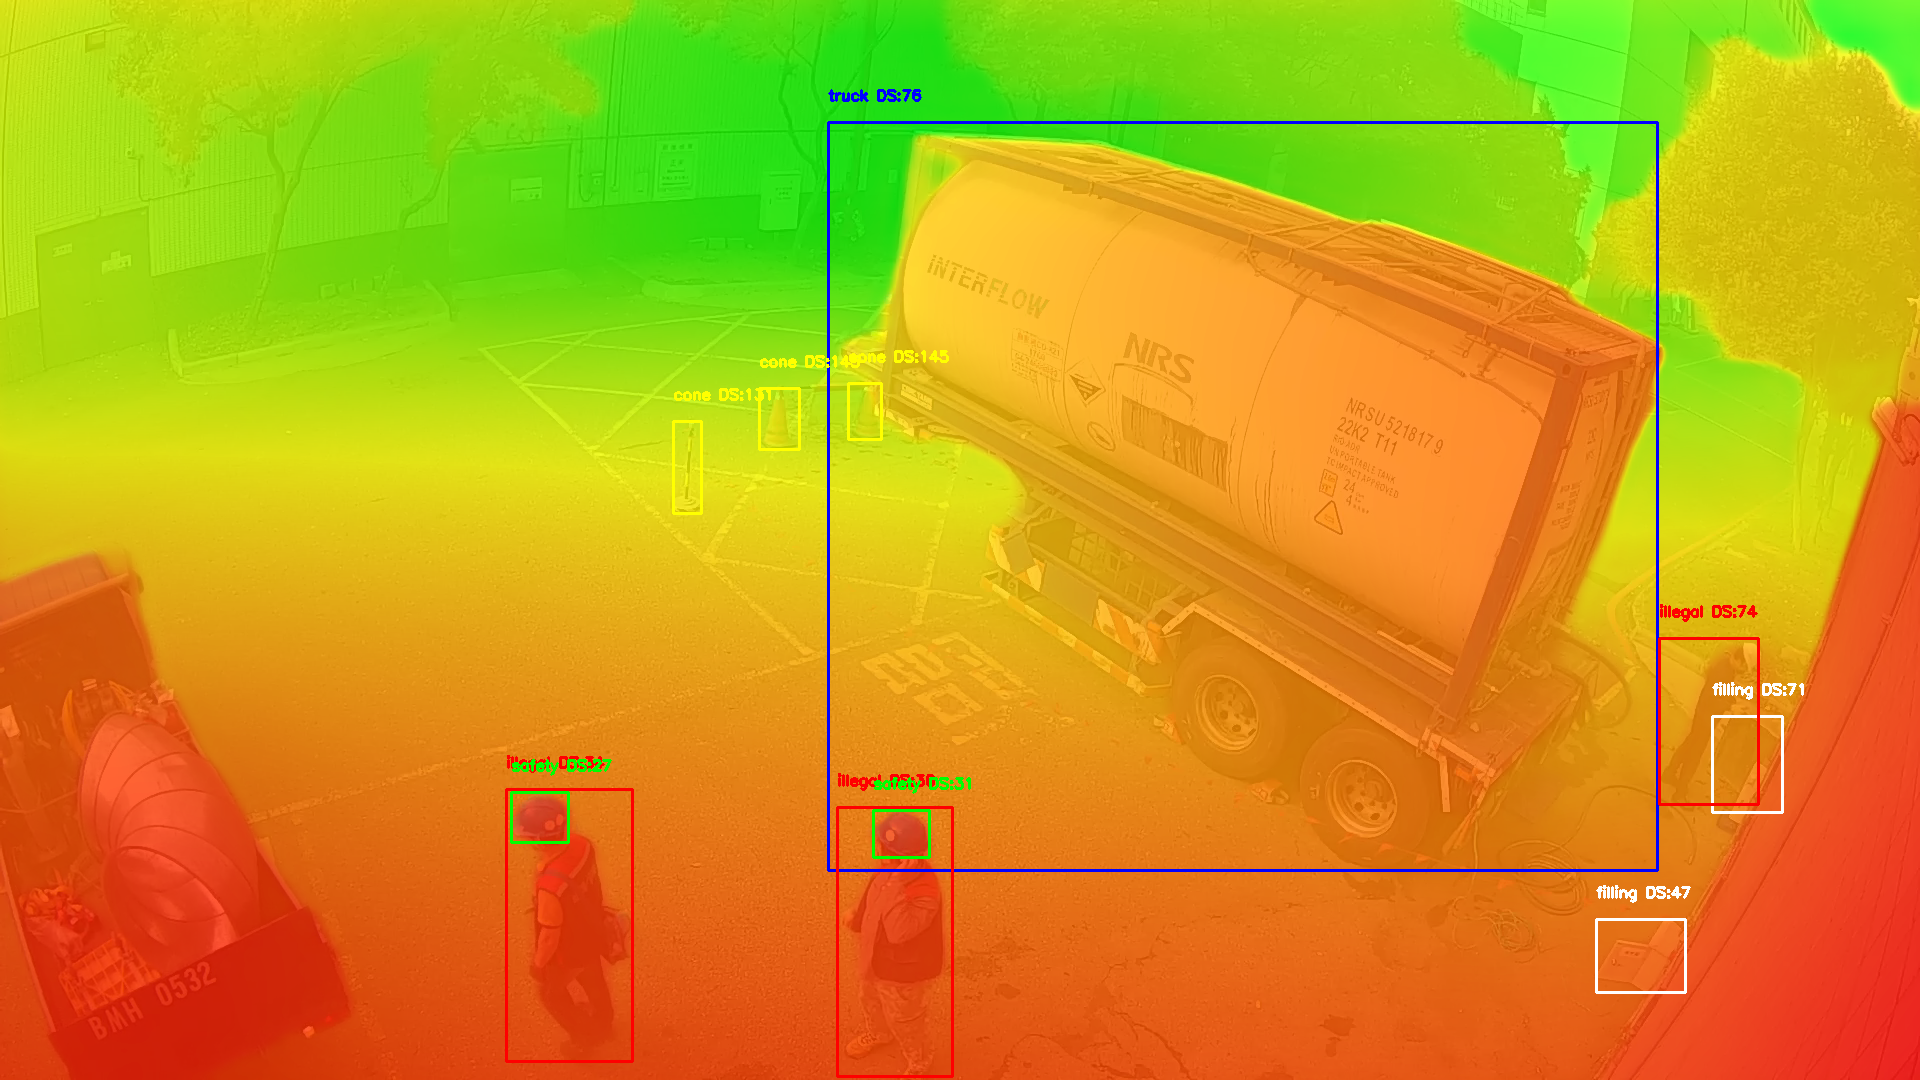

In [11]:
file = 'Demo/4.png'
results,Deep_image = predict_and_process(file,model_zoe_n,yolo)
print(results)
Deep_image